<a href="https://colab.research.google.com/github/som-pat/Resnet-BasevsTL/blob/main/Resnet_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fruits:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5857%2F2609027%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240421%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240421T181627Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7c474f9531c185e4d2a462d4514db211a2c29279a9121008afc978298f46e69702c63b0a8efc3c9384f38c69a14b0f7c77b6def287f81d21cbd09303aaf5979e998c0fbe9b95f77a02698901d0aadfdfff8c13fc9d2fc9ea56dfcc19db2074321cc5a71cc2736df23e7518b5099e94f49cb6b1da90edd321aed7aecbd8e643d9ae0d6960150f24b5e6b2ee03b7e945bef26d9c42b06244f6391797cced5796c330fd46cebf2865fedc91e0cdf8c178b01e09d53d37887c595138e13f623acddeabe679d12cead39a4edec3370edc5d6d8bbf44cb1cc94b906a788514bf11743497888ed8ea5427e0b0f7fd6356432452fee453e561917fd0aade3b811e8ff805'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1379678841 bytes downloaded
Downloaded and uncompressed: fruits
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import numpy
import pandas as pd
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import itertools
from zipfile import ZipFile
from glob import glob
from PIL import Image
import os,random,time,copy
# from resnet import ResidualBlock, ResNet, ResNet50
from tqdm import tqdm

import torch
import torch.nn as  nn
import torch.nn.functional as F

In [4]:
Image_size = [100,100]
epoch = 16
batch_size = 64

In [5]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [6]:
train_path = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training'
test_path = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test'
classes = len(os.listdir(train_path))

In [7]:
transform_train = transforms.Compose([
            transforms.Resize(Image_size),
            # transforms.GaussianBlur(kernel_size = (3,3),sigma = (0.5,5)),
            # transforms.Grayscale(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_test = transforms.Compose([
            transforms.Resize(Image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])

In [8]:
train = datasets.ImageFolder(train_path,transform_train)
test = datasets.ImageFolder(test_path, transform_test)
tlen = int(len(train)-0.25*(len(train)))
train,valid = random_split(train,[tlen,len(train)-tlen])

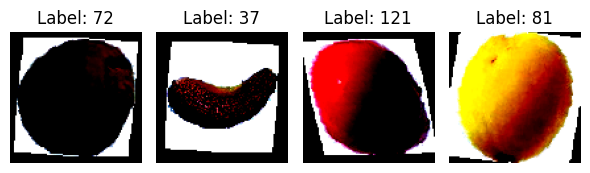

In [9]:
fig, axs = plt.subplots(1,4, figsize=(6, 6))  # Create a horizontal line of subplots
j = random.randint(120,1029)
for i in range(4):
    image, label = train[j+i]
    axs[i].imshow(image.permute(1, 2, 0))   # Display the grayscale image
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')  # Turn off axis labels and ticks

plt.tight_layout()
plt.show()

In [10]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [11]:
image,labels = next(iter(train_loader))
print(image.shape)
print(labels.shape)
print(classes)

torch.Size([64, 3, 100, 100])
torch.Size([64])
131


In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels,out_channels, stride=1,downsample=None):
        super(ResidualBlock,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,padding =1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out+= residual
        out = self.relu(out)
        return out






class ResNet(nn.Module):
    def __init__(self, blocks,layers,num_classes):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                    nn.Conv2d(3, 64, kernel_size=5,stride=2,padding=3),
                    nn.BatchNorm2d(64),
                    nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.layer0 = self.make_layer(blocks,64,layers[0],stride=1)
        self.layer1 = self.make_layer(blocks,128,layers[1],stride=2)
        self.layer2 = self.make_layer(blocks,256,layers[2],stride=2)
        self.layer3 = self.make_layer(blocks,512,layers[3],stride=2)

        self.ap1 = nn.AdaptiveAvgPool2d((1,1))

        self.fc = nn.Sequential(
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,num_classes))


    def make_layer(self, block,planes,blocks,stride=1):
        downsample =None
        if stride!=1 or self.inplanes!=planes:
            downsample =nn.Sequential(
                nn.Conv2d(self.inplanes,planes,kernel_size=1,stride=stride),
                nn.BatchNorm2d(planes)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride,downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self,x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.ap1(x)
        x = x.reshape(x.shape[0], -1)
        # x = x.view(x.size(0),-1)
        x = self.fc(x)

        return x

def ResNet50(num_classes):
    return ResNet(ResidualBlock, [3,4,6,3], num_classes)

def ResNet101(num_classes):
    return ResNet(ResidualBlock, [3,4,23,3], num_classes)

In [13]:
pre_train50 = ResNet50(classes).to(device)
pre_train101 = ResNet101(classes).to(device)

In [14]:
pre_train50.fc = nn.Sequential(
                            nn.Linear(512,256),
                            nn.ReLU(),
                            nn.Linear(256,classes))
pre_train101.fc = nn.Sequential(
                            nn.Linear(512,256),
                            nn.ReLU(),
                            nn.Linear(256,classes))

In [15]:
rnet_50 = pre_train50.to(device)
rnet_101 =pre_train101.to(device)

In [16]:
# images, labels = next(iter(train_loader))
# with torch.no_grad():
#     running_loss = 0.0
#     running_corrects = 0.0
#     images = images.to(device)
#     labels = labels.to(device)
#     output = pre_train(images)
#     _, preds = torch.max(output, 1)
#     loss = criterion(output, labels)
#      # taking the highest value of prediction.
#     running_loss += loss.item()*images.size(0)
#     print(preds)
#     print(labels.data)
#     running_corrects += torch.sum(preds == labels.data).detach().cpu().numpy()
#     total = labels.size(0)
# print(1*images.size(0))

# print(running_corrects)

# print(running_corrects/total *100)




In [17]:
# def accuracy(outputs, labels):
#     _, preds = torch.max(outputs, dim=1)
#     return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [18]:
def model_train(model):


    running_loss_history = []
    running_corrects_history = []
    val_running_loss_history = []
    val_running_corrects_history = []

    num_epochs = 6
    total_step = len(train_loader)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, betas=(0.9, 0.999))


    for epoch in range(1, num_epochs+1):
        running_loss = 0.0
        running_corrects = 0.0
        val_running_loss = 0.0
        val_running_corrects = 0.0

        ###################
        # train the model #
        ###################

        model.train()
        for images,labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()
            # update training loss
            running_loss += loss.item()*images.size(0)
            _, preds = torch.max(output, 1) # taking the highest value of prediction.
            running_corrects += torch.sum(preds == labels.data).detach().cpu().numpy()
        epoch_loss = running_loss/len(train_loader.dataset)
        epoch_acc = running_corrects/ len(train_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        ######################
        # validate the model #
        ######################
        # eval mode (no dropout)
        model.eval()
        with torch.no_grad():
            for val_images,val_labels in tqdm(valid_loader):
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                val_output = model(val_images)
                # calculate the batch loss
                loss = criterion(val_output, val_labels)
                # update average validation loss

                _, val_preds = torch.max(val_output, 1)
                val_running_loss += loss.item()*val_images.size(0)
                val_running_corrects += torch.sum(val_preds == val_labels.data).detach().cpu().numpy()

        val_epoch_loss = val_running_loss/len(valid_loader.dataset)
        val_epoch_acc = val_running_corrects/ len(valid_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print('epoch :', (epoch))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss,epoch_acc))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc))

    return running_loss_history,val_running_loss_history,running_corrects_history,val_running_corrects_history

In [ ]:
running_loss_history,val_running_loss_history,running_corrects_history,val_running_corrects_history = model_train(rnet_50)

100%|██████████| 265/265 [00:32<00:00,  8.06it/s]


epoch : 1
training loss: 3.2414, acc 0.3063 
validation loss: 1.3292, validation acc 0.7453 


 81%|████████  | 645/794 [01:50<00:24,  6.02it/s]

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(running_loss_history)
plt.plot(val_running_loss_history)
plt.title("Resnet_50 Fruits Loss curves")
plt.legend(["Train loss", "Valid loss"])
plt.xlabel("Iteration")
plt.ylabel("Accuaracy")
plt.show()

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(running_corrects_history)
plt.plot(val_running_corrects_history)
plt.title("Resnet_50 Fruits detection Accuracy")
plt.legend(["Train Acc", "Valid Acc"])
plt.xlabel("Iteration")
plt.ylabel("Accuaracy")
plt.show()

In [ ]:
running_loss_history,val_running_loss_history,running_corrects_history,val_running_corrects_history = model_train(rnet_101)

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(running_loss_history)
plt.plot(val_running_loss_history)
plt.title("Fruits Loss curves")
plt.legend(["Train loss", "Valid loss"])
plt.xlabel("Iteration")
plt.ylabel("Accuaracy")
plt.show()

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(running_corrects_history)
plt.plot(val_running_corrects_history)
plt.title("Fruits detection Accuracy")
plt.legend(["Train Acc", "Valid Acc"])
plt.xlabel("Iteration")
plt.ylabel("Accuaracy")
plt.show()

In [ ]:
def model_test(model):

    test_loss = 0.0
    class_correct = list(0. for i in range(classes))
    class_total = list(0. for i in range(classes))
    criterion = nn.CrossEntropyLoss()

    model.eval()

    for image, target in tqdm(test_loader):

        image = image.to(device)
        target = target.to(device)
        with torch.no_grad():
            output = model(image)
            loss = criterion(output, target)
        test_loss += loss.item()*image.size(0)
        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        if len(target) == 64:
            for i in range(64):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

#   for i in range(classes):
#       if class_total[i] > 0:
#           print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
#               classes[i], 100 * class_correct[i] / class_total[i],
#               np.sum(class_correct[i]), np.sum(class_total[i])))
#       else:
#           print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
model_test(rnet_50)

In [ ]:
model_test(rnet_101)